In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2

In [49]:
image_size = (50,50)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers",
    validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "flowers",
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4323 files belonging to 5 classes.
Using 3027 files for training.
Found 4323 files belonging to 5 classes.
Using 1296 files for validation.


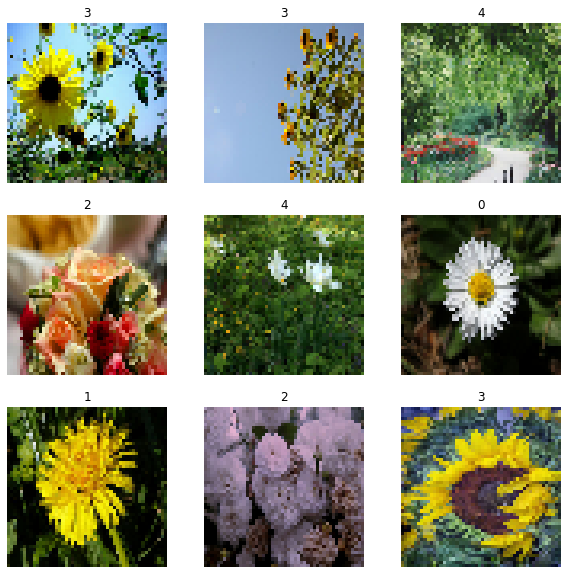

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [60]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

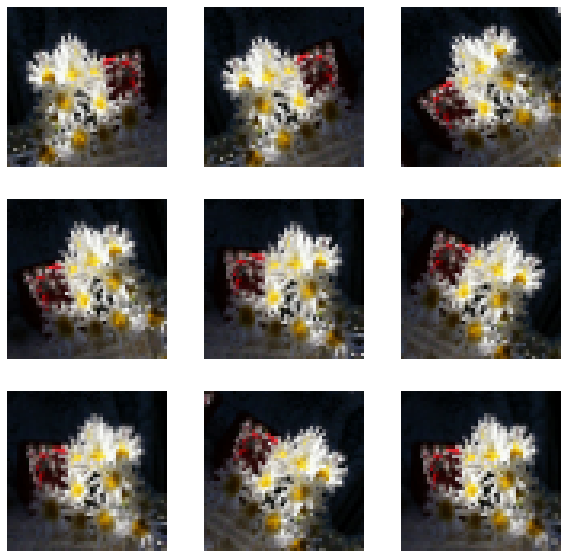

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [62]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [84]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(5, activation="softmax")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)

In [65]:
epochs = 50

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 50, 50, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 50, 50, 3)    0           sequential_2[1][0]               
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 25, 25, 32)   896         rescaling_2[0][0]                
____________________________________________________________________________________________

In [66]:
with tf.device('/device:GPU:1'):
     %time fit_model = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50
95/95 [==============================] - 708s 7s/step - loss: 1.4195 - accuracy: 0.4396 - val_loss: 1.5989 - val_accuracy: 0.2546
Epoch 2/50
95/95 [==============================] - 100s 1s/step - loss: 1.1114 - accuracy: 0.5731 - val_loss: 1.7153 - val_accuracy: 0.2546
Epoch 3/50
95/95 [==============================] - 101s 1s/step - loss: 0.9858 - accuracy: 0.6442 - val_loss: 2.1133 - val_accuracy: 0.2546
Epoch 4/50
95/95 [==============================] - 98s 1s/step - loss: 0.9253 - accuracy: 0.6489 - val_loss: 2.4085 - val_accuracy: 0.2546
Epoch 5/50
95/95 [==============================] - 100s 1s/step - loss: 0.9089 - accuracy: 0.6629 - val_loss: 2.2593 - val_accuracy: 0.2577
Epoch 6/50
95/95 [==============================] - 101s 1s/step - loss: 0.8333 - accuracy: 0.6933 - val_loss: 1.3883 - val_accuracy: 0.4622
Epoch 7/50
95/95 [==============================] - 99s 1s/step - loss: 0.8223 - accuracy: 0.6852 - val_loss: 1.0852 - val_accuracy: 0.6134
Epoch 8/50
95/9

In [74]:
model.evaluate(val_ds)

41/41 [==============================] - 10s 229ms/step - loss: 1.1270 - accuracy: 0.7438


[1.1269880533218384, 0.7438271641731262]